In [ ]:
##########Linking to Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#to write weights
import h5py

In [ ]:
######Preprocessing the training and validation datasets
import os
import zipfile
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define our example directories and files
base_dir = '/content/gdrive/MyDrive/dataset'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')


train_0_dir = os.path.join(train_dir, '0')
train_1_dir = os.path.join(train_dir, '1')
train_2_dir = os.path.join(train_dir, '2')
train_3_dir = os.path.join(train_dir, '3')
train_4_dir = os.path.join(train_dir, '4')
train_5_dir = os.path.join(train_dir, '5')

validation_0_dir = os.path.join(validation_dir, '0')
validation_1_dir = os.path.join(validation_dir, '1')
validation_2_dir = os.path.join(validation_dir, '2')
validation_3_dir = os.path.join(validation_dir, '3')
validation_4_dir = os.path.join(validation_dir, '4')
validation_5_dir = os.path.join(validation_dir, '5')

train_0_fnames = os.listdir(train_0_dir)
train_1_fnames = os.listdir(train_1_dir)
train_2_fnames = os.listdir(train_2_dir)
train_3_fnames = os.listdir(train_3_dir)
train_4_fnames = os.listdir(train_4_dir)
train_5_fnames = os.listdir(train_5_dir)

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=0,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# Note that the validation data should not be augmented!
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        directory = train_dir, # This is the source directory for training images
        target_size=(299, 299),  # All images will be resized to 299x299
        color_mode = 'rgb', 
        batch_size=10,
        class_mode='categorical')

# Flow validation images in batches of 10 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        directory = validation_dir,
        target_size=(299, 299),
        batch_size=10,
        class_mode='categorical')

Found 3616 images belonging to 6 classes.
Found 608 images belonging to 6 classes.


In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2021-05-21 10:48:42--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.137.128, 142.250.101.128, 142.250.141.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.137.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  92.0MB/s    in 0.9s    

2021-05-21 10:48:43 (92.0 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [ ]:
#save weights
from keras.callbacks import ModelCheckpoint
weights_file = '/content/gdrive/MyDrive/weights.hdf5'
checkpoint = ModelCheckpoint(weights_file, monitor='acc', mode='max', save_best_only=True, verbose=1)

In [ ]:
######Loading the pretrained InceptionV3 model
import os
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = InceptionV3(
    input_shape=(299, 299, 3), include_top=False, weights=None)
#input_shape is size of picture and 3 is RGB channel
pre_trained_model.load_weights(local_weights_file)

In [ ]:
#######Specifing the layer we will use in Inception v3
for layer in pre_trained_model.layers:
  layer.trainable = False

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 17, 17, 768)


In [ ]:
####Establishing the model based on the selected layers in Inception v3
###### a stratergy of "Dropout" is also used  

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output) 
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final layer for classification
x = layers.Dense(6, activation='softmax')(x)

# Configure and compile the model
model = Model(pre_trained_model.input, x)
#model.compile(loss='categorical_crossentropy',
#              optimizer=RMSprop(lr=0.0001),
#              metrics=['acc'])

In [ ]:
############Further Improving Accuracy with Fine-Tuning
#from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam

unfreeze = False

# Unfreeze all models after "mixed6"
for layer in pre_trained_model.layers:
  if unfreeze:
    layer.trainable = True
  if layer.name == 'mixed6':
    unfreeze = True

# As an optimizer, here we will use SGD 
# with a very low learning rate (0.00001)
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(
                  learning_rate=0.001, 
                  epsilon=0.1),
              metrics=['acc'])

In [ ]:
####Retraining and validating the model

history = model.fit_generator(
      train_generator,
      steps_per_epoch=60,
      validation_data=validation_generator,
      validation_steps=10,
      epochs=100,
      verbose=2)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
60/60 - 371s - loss: 1.4908 - acc: 0.4217 - val_loss: 1.1804 - val_acc: 0.5700
Epoch 2/100
60/60 - 278s - loss: 1.1085 - acc: 0.5683 - val_loss: 1.1148 - val_acc: 0.5800
Epoch 3/100
60/60 - 247s - loss: 0.9756 - acc: 0.6233 - val_loss: 0.8204 - val_acc: 0.7000
Epoch 4/100
60/60 - 204s - loss: 0.8519 - acc: 0.6767 - val_loss: 1.0715 - val_acc: 0.6000
Epoch 5/100
60/60 - 171s - loss: 0.7909 - acc: 0.7167 - val_loss: 0.6597 - val_acc: 0.7500
Epoch 6/100
60/60 - 148s - loss: 0.7128 - acc: 0.7417 - val_loss: 1.0148 - val_acc: 0.5700
Epoch 7/100
60/60 - 136s - loss: 0.7373 - acc: 0.7383 - val_loss: 0.5017 - val_acc: 0.8500
Epoch 8/100
60/60 - 109s - loss: 0.7195 - acc: 0.7450 - val_loss: 0.5664 - val_acc: 0.7700
Epoch 9/100
60/60 - 91s - loss: 0.5903 - acc: 0.7817 - val_loss: 0.7130 - val_acc: 0.7100
Epoch 10/100
60/60 - 66s - loss: 0.6196 - acc: 0.7750 - val_loss: 0.6304 - val_acc: 0.7600
Epoch 11/100
60/60 - 62s - loss: 0.4961 - acc: 0.8100 - val_loss: 0.4884 - val_acc: 0.8200


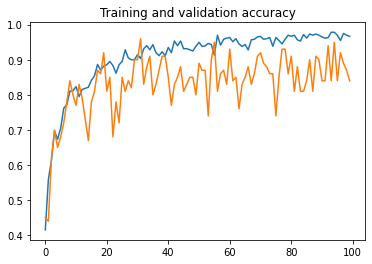

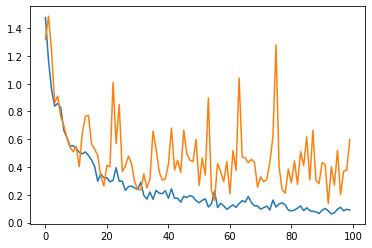

In [ ]:
#######Ploting the training and validation loss and accuracy to show it conclusively
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)

In [ ]:
#saving existing model
model.save('/content/gdrive/MyDrive/my_model.h5')


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/savedmodel/assets


In [ ]:
######Using the retaiend model to predict mutiple new unknown iamges in a folder in Googel Drive
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
# image folder
folder_path = '/content/gdrive/My Drive/dataset/validation/0'

# dimensions of images
img_width, img_height = 299, 299

# load all images into a list
images = []
for img in os.listdir(folder_path):
    img = os.path.join(folder_path, img)
    img = cv2.imread(img) 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (img_width,img_height), interpolation = cv2.INTER_AREA)
    img = img.astype("float")/255.0 
    images.append(img)
images = np.asarray(images) 

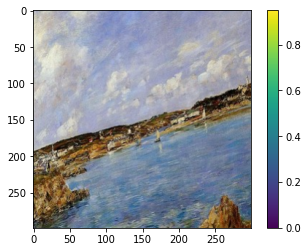

In [ ]:
####checking the images feeded to the model
plt.figure()
plt.imshow(images[0])
plt.colorbar()
plt.grid(False)
plt.show()  

In [ ]:
####Predicting

classes = model.predict(images, batch_size=10)
#print(classes)
i = 0

for clas in classes:
  if clas.tolist().index(max(clas.tolist())) != 3:
    i+=1

print(i)

12


In [ ]:
#####list of all filenames
os.listdir(folder_path)

In [ ]:
train_generator.class_indices

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5}

(1, 6)
[[1.4310203e-05 2.8443727e-08 3.3890212e-06 1.2700408e-08 9.9998224e-01
  3.0525895e-09]]
too dark


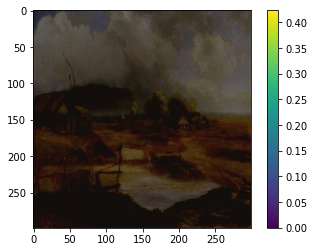

In [ ]:
#Follow these steps to make a prediction from a new file
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import numpy as np
#Load the image from disk
test_x = [] 
image = cv2.imread("/content/gdrive/MyDrive/pics/pic3.jpg") 
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (299,299), interpolation = cv2.INTER_AREA) 
test_x.append(image)

#Then pre-process the test image:
test_x = np.asarray(test_x) 
test_processed_x = test_x.astype("float")/255.0
#Then you can predict from your model like this:

test_predictions = model.predict(test_processed_x, batch_size=1) 
print(test_predictions.shape) 
print(test_predictions)
res = max(*test_predictions.tolist())   
problem = test_predictions.tolist()[0].index(res)
if problem == 0: 
  print('all right!')
elif problem == 1:
  print('horizon crooked to the left') 
elif problem == 2: 
  print('not realistic enough') 
elif problem is 3:
  print('horizon crooked to the right') 
elif problem == 4: 
  print('too dark') 
elif problem == 5: 
  print('too bright') 

plt.figure()
plt.imshow(test_processed_x[0])
plt.colorbar()
plt.grid(False)
plt.show()

In [ ]:
#terminate the kernel and free memory resources
import os, signal
os.kill(os.getpid(), signal.SIGKILL)